[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/0xInode/AI-study-notes/blob/main/ml/hands-on-ml/chapter06/chapter06.ipynb)


# Decision Trees

SVM과 마찬가지로 결정 트리(Decision Trees)는 분류(classification) 회귀(regression) 작업 모두에 사용 가능  
다중 출력 작업(multioutput tasks)에도 사용 가능  
복잡한 데이터셋에도 잘 맞출 수 있을 정도로 강력한 알고리즘  
2장에서 캘리포니아 주택 데이터셋에 대해 DecisionTreeRegressor 모델을 훈련시켜 완벽하게(사실 과적합되도록) 학습시킨 적 있음

결정 트리는 랜덤 포레스트(Random Forests, 7장)의 핵심 구성 요소  
랜덤 포레스트는 현재 가장 강력한 머신러닝 알고리즘 중 하나

- 결정 트리 훈련, 시각화, 예측  
- Scikit-Learn에서 사용하는 CART 훈련 알고리즘  
- 트리의 규제 방법과 회귀 작업에서의 활용 방법  
- 결정 트리의 한계점

## Set up

In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "decision_trees"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Training and Visualizing a Decision Tree

In [6]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris(as_frame=True)  # Iris 데이터셋 불러옴 (DataFrame 형태)
X_iris = iris.data[["petal length (cm)", "petal width (cm)"]].values  # 특성: 꽃잎 길이와 너비만 선택
y_iris = iris.target  # 타깃: 꽃 종류

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)  # 최대 깊이 2인 결정 트리 모델 생성
tree_clf.fit(X_iris, y_iris)  # 모델 학습


DecisionTreeClassifier(max_depth=2, random_state=42)

학습된 Decision Tree를 시각화  
`export_graphviz()` 메서드 사용-> `iris_tree.dot`이라는 그래프 정의 파일 출력

In [7]:
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=str(IMAGES_PATH / "iris_tree.dot"),  # 트리 구조를 .dot 파일로 저장함 (시각화를 위한 중간 파일)
        feature_names=["petal length (cm)", "petal width (cm)"],  # 트리 노드에 표시할 특성 이름 지정
        class_names=iris.target_names,  # 클래스(품종) 이름을 보기 좋게 표시
        rounded=True,  # 트리 노드 모양을 둥글게 만들어 가독성 높임
        filled=True  # 노드에 클래스별 색을 채워 시각적으로 구분
    )


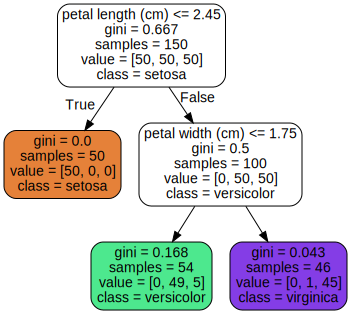

In [9]:
from graphviz import Source

Source.from_file(IMAGES_PATH / "iris_tree.dot")

In [11]:
!dot -Tpng {IMAGES_PATH / "iris_tree.dot"} -o {IMAGES_PATH / "iris_tree.png"} # .dot 파일을 .png 파일로

## Making Predictions

위 트리가 어떻게 예측을 수행하는지 살펴보기

어떤 붓꽃을 발견해서 분류하고 싶다고 가정  
먼저 트리의 루트 노드(깊이 0, 가장 위)에서 시작  
이 노드는 꽃잎의 길이가 2.45cm보다 짧은지 질문

만약 그렇다면 루트의 왼쪽 자식 노드(깊이 1, 왼쪽)로  
이 경우 해당 노드는 리프 노드(자식 노드가 없음)  
질문 없이 바로 해당 노드의 예측 클래스를 확인  
-> Iris setosa (class=setosa)라고 예측

다른 꽃의 꽃잎 길이가 2.45cm보다 큼  
그러면 루트의 오른쪽 자식 노드(깊이 1, 오른쪽)로 이동  
이 노드는 리프가 아니므로 또 다른 질문   
꽃잎의 너비가 1.75cm보다 작은가?   
만약 그렇다면 이 꽃은 Iris versicolor일 가능성이 높음(깊이 2, 왼쪽)   
그렇지 않다면 Iris virginica일 가능성이 높음(깊이 2, 오른쪽)

Decision Tree의 장점 중 하나는 데이터 전처리를 거의 필요로 하지 않는다는 것    
특징 스케일링이나 정규화를 전혀 하지 않아도 됨
   
samples 속성: 해당 노드에 해당하는 훈련 샘플의 개수  
꽃잎 길이가 2.45cm보다 큰 훈련 샘플은 100개(깊이 1, 오른쪽)  
그중에서 꽃잎 너비가 1.75cm보다 작은 샘플은 54개(깊이 2, 왼쪽)  

value 속성: 해당 노드에 포함된 각 클래스별 샘플 수  
맨 아래 오른쪽 노드는 Iris setosa: 0, Iris versicolor: 1, Iris virginica: 45개의 샘플

gini 속성: 불순도  
모든 샘플이 같은 클래스일 경우 gini=0(이 노드는 "순수")  
깊이 1 왼쪽 노드는 오직 Iris setosa 샘플만 포함하므로 gini 점수 0

다음 식은 i번째 노드의 지니 점수 𝐺𝑖 계산

$$
G_i = 1 - \sum_{k=1}^{n} p_{i,k}^2
$$


$p_{i,k}$는 i번째 노드에 있는 훈련 샘플 중 클래스 k에 속하는 샘플의 비율

Scikit-Learn은 CART 알고리즘 사용 -> **항상 이진 트리(binary tree)** 생성  
=> 리프 노드가 아닌 노드는 항상 자식 노드가 두 개, 질문의 결과는 항상 yes/no

ID3 같은 다른 알고리즘은 두 개 이상 자식을 가진 트리를 만들 수 있음


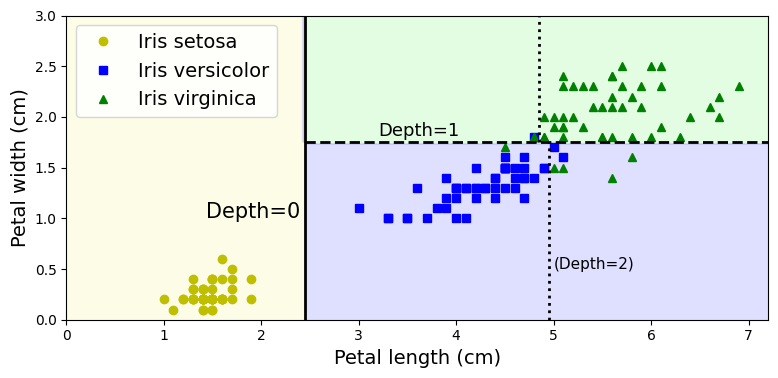

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# 시각화를 위한 컬러맵 설정
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
plt.figure(figsize=(8, 4))

# 꽃잎 길이/너비 값들의 조합으로 2D 그리드 생성
lengths, widths = np.meshgrid(np.linspace(0, 7.2, 100), np.linspace(0, 3, 100))
X_iris_all = np.c_[lengths.ravel(), widths.ravel()]

# 전체 그리드에 대해 트리 모델의 예측 수행
y_pred = tree_clf.predict(X_iris_all).reshape(lengths.shape)

# 결정 경계 시각화
plt.contourf(lengths, widths, y_pred, alpha=0.3, cmap=custom_cmap)

# 실제 데이터 포인트 시각화
for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris[:, 0][y_iris == idx], X_iris[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

# max_depth=3인 새로운 트리 학습 → 더 깊은 경계를 그리기 위함
tree_clf_deeper = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf_deeper.fit(X_iris, y_iris)

# 트리에서 사용된 분할 기준 추출
th0, th1, th2a, th2b = tree_clf_deeper.tree_.threshold[[0, 2, 3, 6]]

# 트리 깊이별 경계선 시각화
plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")
plt.plot([th0, th0], [0, 3], "k-", linewidth=2)        # Depth 0
plt.plot([th0, 7.2], [th1, th1], "k--", linewidth=2)   # Depth 1
plt.plot([th2a, th2a], [0, th1], "k:", linewidth=2)    # Depth 2 왼쪽
plt.plot([th2b, th2b], [th1, 3], "k:", linewidth=2)    # Depth 2 오른쪽

# 텍스트 라벨 표시
plt.text(th0 - 0.05, 1.0, "Depth=0", horizontalalignment="right", fontsize=15)
plt.text(3.2, th1 + 0.02, "Depth=1", verticalalignment="bottom", fontsize=13)
plt.text(th2a + 0.05, 0.5, "(Depth=2)", fontsize=11)

# 축 범위 및 범례 설정
plt.axis([0, 7.2, 0, 3])
plt.legend()

# 이미지 저장 (save_fig는 따로 정의되어 있어야 함)
save_fig("decision_tree_decision_boundaries_plot")

# 그래프 출력
plt.show()


위 그림은 이 결정 트리의 **결정 경계(decision boundaries)**를 보여 줌  
- 굵은 세로선: 루트 노드(깊이 0)의 결정 경계(꽃잎 길이 = 2.45cm)  
- 왼쪽 영역: 순수(Iris setosa만 있음) → 더 이상 분할 X
- 오른쪽 영역: 불순 → 깊이 1의 오른쪽 노드가 꽃잎 너비 = 1.75cm에서 다시 분할(점선)  

max_depth가 2로 설정되어 있었기 때문에 트리는 여기서 멈춤  
max_depth=3으로 설정했다면, 깊이 2의 두 노드도 추가로 결정 경계 생성했을 것 (점선보다 더 얇은 점선으로 표시)

In [14]:
tree_clf.tree_ # 실제 트리 구조에 접근

**모델 해석: 화이트 박스 vs 블랙 박스**

Decision Tree는 직관적, 결정 과정 이해 쉬움
-> **화이트 박스 모델(white box model)**이라고 불림

Random Forest나 Neural Network 같은 모델 -> **블랙 박스 모델(black box model)**로 간주  
예측 성능은 뛰어나고, 예측 과정에서 어떤 계산이 이뤄졌는지는 확인할 수 있음  
하지만 왜 그런 예측이 나왔는지를 단순하게 설명하기 어려움

어떤 신경망 모델이 사진 속 인물이 누구인지를 예측했다고 해도  
그 예측에 무엇이 영향을 줬는지는 알기 어려움  
(눈, 입, 신발, 소파 때문인지 알 수 없음)

Decision Tree는 간단하고 명확한 분류 규칙 제공  
필요하다면 사람이 수동으로 적용할 수도(예: 꽃 분류)

## Estimating Class Probabilities

결정 트리는 어떤 샘플이 특정 클래스 𝑘에 속할 확률도 예측할 수 있음
1. 해당 샘플이 도달하는 리프 노드를 찾고
2. 그 노드에 있는 훈련 샘플 중 클래스 𝑘의 비율을 확률로 반환

예를 들어 꽃잎 길이가 5cm, 너비가 1.5cm인 꽃이라면  
이 샘플은 깊이 2의 왼쪽 노드에 도달

이 노드에는 다음과 같은 클래스 분포:
- Iris setosa: 0개 → 확률 0% (0/54)
- Iris versicolor: 49개 → 확률 약 90.7% (49/54)
- Iris virginica: 5개 → 확률 약 9.3% (5/54)

따라서 클래스 예측 결과는 가장 높은 확률을 가진  
**Iris versicolor (클래스 1)**가 됨

In [15]:
# [5, 1.5] 특성값에 대한 각 클래스별 예측 확률을 소수점 3자리로 반올림해 출력
tree_clf.predict_proba([[5, 1.5]]).round(3)


array([[0.   , 0.907, 0.093]])

In [16]:
# [5, 1.5] 특성값에 대해 가장 확률이 높은 클래스를 예측
tree_clf.predict([[5, 1.5]])


array([1])

아까 그래프의 오른쪽 아래 사각형 내에서는 어떤 좌표든 같은 리프 노드에 도달하므로 확률 예측은 항상 동일  
예: 꽃잎 길이가 6cm이고 너비가 1.5cm여도 마찬가지

비록 육안으로 봤을 땐 Iris virginica일 가능성이 더 커 보이지만,  
트리는 현재의 학습 데이터와 구조만 보고 판단하기 때문에 그렇게 예측하지 않음

## The CART Training Algorithm

Scikit-Learn은 결정 트리를 학습할 때   
CART(Classification and Regression Tree) 알고리즘 사용  
(결정 트리를 “성장시킨다”라고도 표현)

이 알고리즘은 먼저 훈련 데이터를 하나의 특성 𝑘와 임계값 $𝑡_𝑘$를 사용해서 두 부분으로 나눔  
(예: petal length ≤ 2.45 cm)

𝑘와 $𝑡_𝑘$ 선택 방법  
→ 알고리즘은 (k, $𝑡_𝑘$)의 조합 중에서 두 개의 부분 집합이 가장 순수해지는 조합을 찾음(단, 각 집합의 크기에 따라 가중치 줌)

$$
J(k, t_k) = \frac{m_{\text{left}}}{m} G_{\text{left}} + \frac{m_{\text{right}}}{m} G_{\text{right}}
$$


$𝐺_{left/right}$: 좌/우 노드의 불순도 (예: gini)

$𝑚_{left/right}$: 좌/우 노드에 속한 샘플 수

𝑚: 현재 노드의 총 샘플 수
→ 전체 불순도를 최소화하는 분할 선택

[트리 생성 과정]
1. 위 방식으로 데이터를 두 개로 나눔
2. 각 부분 집합에 대해 같은 과정을 재귀적으로 반복
3. 아래 조건 중 하나라도 만족하면 멈춤:
- 최대 깊이 (max_depth)에 도달함
- 더 이상 불순도를 줄일 분할을 찾을 수 없음
- 기타 하이퍼파라미터 조건 도달:
  - min_samples_split
  - min_samples_leaf
  - min_weight_fraction_leaf
  - max_leaf_nodes

CART는 탐욕 알고리즘(Greedy Algorithm)이므로  
매 단계마다 즉시 가장 좋은 분할만 선택함  
몇 단계 뒤까지 고려해서 최적을 찾지 않음  
그래서 결과가 전역 최적 트리가 될 보장은 없음

최적 트리를 찾는 건 NP-완전 문제  
최적 트리를 찾으려면 $O(\exp(m))$ 시간 필요  
-> 훈련 샘플이 조금만 많아도 계산 불가능

그래서 현실적으로는 **괜찮은 수준의 트리**에 만족해야

## Computational Complexity

예측을 수행하려면 결정 트리를 루트에서 리프까지 따라 내려가야 함
결정 트리는 일반적으로 대략적으로 균형 잡혀 있으므로, 예측을 위해 약
$O(\log_2 (m))$
개의 노드 통과  
각 노드에서는 한 개의 특성 값만 확인하면 되므로,   
전체 예측 복잡도는 $O(\log_2 (m))$
이며 특성 수와는 무관  
따라서 훈련 샘플 수가 많더라도 예측은 매우 빠르게 수행됨  

훈련 알고리즘은 각 노드에서 모든 특성(또는 max_features가 설정된 경우 그보다 적은 수의 특성)을 모든 샘플에 대해 비교  
각 노드에서 모든 특성과 모든 샘플을 비교하는 것은   
$O(n \times m \log_2(m))$의 훈련 복잡도를 가짐  

훈련 샘플 수가 수천 개 이하로 작은 경우에는  
Scikit-Learn이 데이터를 미리 정렬함으로써 훈련 속도를 높일 수 있음(presort=True)  
하지만 훈련 샘플 수가 많은 경우에는 훈련 속도를 상당히 느리게 만듦



## Gini Impurity or Entropy?

기본적으로는 **지니 불순도(Gini impurity)**가 사용되지만,  
criterion 하이퍼파라미터를 "entropy"로 설정하면 엔트로피(Entropy) 불순도 측정을 대신 사용할 수 있음

엔트로피라는 개념은 원래 **열역학(thermodynamics)**에서 시작되었고,  
분자의 무질서도를 측정하는 데 사용:  
→ 분자들이 정지해 있고 정돈돼 있을수록 엔트로피는 0에 가까움

이 개념은 이후 다양한 분야로 확산되었고,  
특히 **Shannon의 정보 이론(information theory)**에서는  
메시지 하나가 담고 있는 평균 정보량을 측정하는 데 사용됨  
→ 모든 메시지가 동일하면 엔트로피는 0이 됨

머신러닝에서는 엔트로피가 자주 불순도 측정 방법으로 쓰임  
→ 하나의 클래스만 포함된 집합의 엔트로피는 0임

$$
H_i = - \sum_{\substack{k=1 \\ p_{i,k} \ne 0}}^{n} p_{i,k} \log_2 (p_{i,k})
$$


깊이 2 왼쪽 노드의 엔트로피는 $-\left( \frac{49}{54} \log_2 \frac{49}{54} + \frac{5}{54} \log_2 \frac{5}{54} \right) \approx 0.445$


Gini 불순도와 엔트로피 중 무엇을 써야 할까?

대부분의 경우 둘 중 무엇을 사용해도 큰 차이 X  
→ 결과적으로 비슷한 트리

Gini 불순도는 계산이 조금 더 빠르기 때문에 기본값으로 적절

서로 다른 결과가 나올 경우:
- Gini 불순도: 가장 자주 나오는 클래스를 빠르게 분리하는 경향
- 엔트로피: 좀 더 균형 잡힌 트리를 만드는 경향

## Regularization Hyperparameters

결정 트리는 훈련 데이터에 대해 거의 아무런 가정도 하지 않음
(예: 선형 모델은 데이터가 선형이라는 가정)

제약을 걸지 않으면 트리는 훈련 데이터에 매우 잘 맞도록 구조를 스스로 조정  →  대부분 과적합(**비모수 모델(nonparametric model)**)  
→ 매개변수가 없어서가 아니라 훈련 전에 매개변수의 수가 정해져 있지 않기 때문  
→ 모델 구조가 자유롭게 데이터에 맞춰질 수 있음

반대로, 선형 모델 같은 **모수 모델(parametric model)**은  
미리 정해진 수의 매개변수를 가지므로  
자유도가 제한되어 있어 과적합 위험은 줄지만 과소적합 위험은 커짐

과적합을 피하려면 훈련 중 결정 트리의 자유도 제한  
→ **규제(regularization)**

규제 하이퍼파라미터는 알고리즘에 따라 다르지만,  
보통은 **트리의 최대 깊이(max_depth)**를 제한하는 방식이 기본  
→ Scikit-Learn에서는 max_depth 하이퍼파라미터로 설정  
(기본값은 None, 제한 없음)

max_depth를 줄이면 모델 규제, 과적합 위험 감소

DecisionTreeClassifier에 트리의 형태를 제한하는
다른 하이퍼파라미터
- min_samples_split: 노드를 분할하기 위한 최소 샘플 수
- min_samples_leaf: 리프 노드가 가져야 할 최소 샘플 수
- min_weight_fraction_leaf: min_samples_leaf와 같지만, 전체 가중 샘플 수에 대한 비율로 표현
- max_leaf_nodes: 리프 노드의 최대 개수
- max_features: 분할 시 고려할 최대 특성 수

min_* 값을 크게 하거나, max_* 값을 작게 하면 모델이 규제

일부 알고리즘은 처음에는 제약 없이 트리를 만든 뒤,  
불필요한 노드를 **가지치기(pruning)**해서 제거하는 방식으로 작동

자식 노드가 모두 리프인 노드는,  
그 노드의 불순도 개선이 통계적으로 유의미하지 않다면  
→ 불필요한 노드로 간주하고 제거

이때는 $\chi^2$검정(chi-squared test) 같은 표준 통계 검정 사용  
→ 불순도 감소가 우연일 확률(귀무가설)인 p-value 계산  
→ p-value가 설정된 임계값(보통 5%)보다 크면 노드는 제거 대상

이 과정을 반복해 모든 불필요한 노드가 제거될 때까지 가지치기를 계속함

In [17]:
from sklearn.datasets import make_moons

# 노이즈가 포함된 2차원 반달형 데이터셋 생성
X_moons, y_moons = make_moons(n_samples=150, noise=0.2, random_state=42)

# 기본 결정 트리 모델
tree_clf1 = DecisionTreeClassifier(random_state=42)

# 최소 리프 샘플 수를 5로 제한한 트리(일반화 성능 향상 목적)
tree_clf2 = DecisionTreeClassifier(min_samples_leaf=5, random_state=42)

# 두 모델 모두 학습
tree_clf1.fit(X_moons, y_moons)
tree_clf2.fit(X_moons, y_moons)


DecisionTreeClassifier(min_samples_leaf=5, random_state=42)

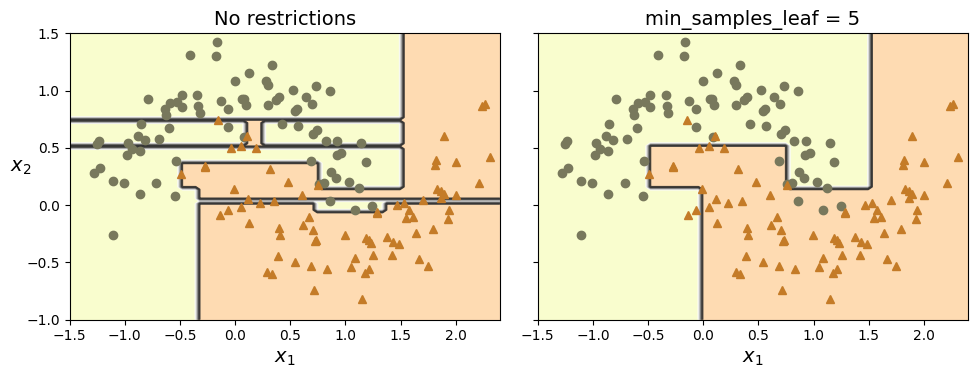

In [18]:
def plot_decision_boundary(clf, X, y, axes, cmap):
    # 결정 경계를 시각화하기 위한 좌표 그리드 생성
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    # 결정 경계 색상 채우기 및 윤곽선
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=cmap)
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8)

    # 클래스별 데이터 포인트 시각화
    colors = {"Wistia": ["#78785c", "#c47b27"], "Pastel1": ["red", "blue"]}
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[cmap][idx], marker=markers[idx], linestyle="none")

    # 축 범위 및 라벨 설정
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

# 두 개의 서브플롯 생성 (비교용)
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

# 첫 번째: 제약 없는 결정 트리
plt.sca(axes[0])
plot_decision_boundary(tree_clf1, X_moons, y_moons,
                       axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia")
plt.title("No restrictions")

# 두 번째: min_samples_leaf 제약 적용한 트리
plt.sca(axes[1])
plot_decision_boundary(tree_clf2, X_moons, y_moons,
                       axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia")
plt.title(f"min_samples_leaf = {tree_clf2.min_samples_leaf}")

# y축 라벨 제거 (중복 방지)
plt.ylabel("")

# 이미지 저장 및 출력
save_fig("min_samples_leaf_plot")
plt.show()


## Regression

## Instability